In [1]:
! git clone https://github.com/mrinath123/Deeplense_Gravitational_lensing.git # cloning our repo
! pip install -q timm #cloning timm for pretrained networks
! pip install -q e2cnn #for ecnn

Cloning into 'Deeplense_Gravitational_lensing'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (113/113), done.ssing objects:  29% (33/113)
remote: Total 151 (delta 61), reused 112 (delta 35), pack-reused 0
Receiving objects: 100% (151/151), 1.52 MiB | 1.72 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
!conda install -q -y gdown #required for downlaoding datasets from google cloud

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.9.14  |       ha878542_0         152 KB  conda-forge
    certifi-2022.9.14          |     pyhd8ed1ab_0         156 KB  conda-forge
    filelock-3.8.0             |     pyhd8ed1ab_0          13 KB  conda-forge
    gdown-4.5.1                |     pyhd8ed1ab_0          17 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         338 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.8.0-pyhd8ed1ab_0
  gdown              conda-forge/noarch::gdown-4.5.1-pyhd8ed1ab_0

The following packages will be UPDATED:

  ca-certificates                      2022.6.15-ha87

In [3]:
# libraries
import timm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm.notebook import tqdm
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import math
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
from transformers import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
from sklearn import  model_selection

In [4]:
#making the paths of the repo and the notbook same
sys.path.insert(0, './Deeplense_Gravitational_lensing/Lensing_DomainAdaptation')

In [5]:
#importing frompur repo
from e2cnn import gspaces
import e2cnn.nn as e2nn
from models import *
from pretraining import *
from utils import *
from dataset import *
from ADAmatch import *

# Source data

In [6]:
# downloading them
!gdown http://drive.google.com/uc?id=1cRjseeUQhab5TRRb0NDmFxjGdsd0Fwo0
!gdown http://drive.google.com/uc?id=1MJ-k5xWiww6IFauu7oqqD6mzKfJiMo3r

Downloading...
From: http://drive.google.com/uc?id=1cRjseeUQhab5TRRb0NDmFxjGdsd0Fwo0
To: /kaggle/working/hsc2.zip
100%|████████████████████████████████████████| 621M/621M [00:07<00:00, 84.8MB/s]
Downloading...
From: http://drive.google.com/uc?id=1MJ-k5xWiww6IFauu7oqqD6mzKfJiMo3r
To: /kaggle/working/hsc_lens_smooth.zip
100%|████████████████████████████████████████| 638M/638M [00:07<00:00, 82.0MB/s]


In [7]:
!unzip -q hsc2.zip
!unzip -q hsc_lens_smooth.zip
cls1 = os.listdir("./hsc") # class 1 (non-lensing)
cls2 = os.listdir("./hsc_lens_smooth") # class 2 (lensing)
cls1 = ['./hsc/' + i for  i in cls1 ]
cls2 = ['./hsc_lens_smooth/' + i for  i in cls2]

In [8]:
cls2 = cls2[:400] # only 400 files from class 2 is used, to make the data imblalanced and match the target data, you can skip if you want

In [9]:
X_train, X_val , X_test = prep_data(cls1 , cls2) # first argument is for non-lensing images
X_train.shape , X_val.shape , X_test.shape

((27276, 2), (9093, 2), (4041, 2))

# Target data

In [10]:
!unzip -q -no ../input/lensing-data-xploration/hsc2.zip
!unzip -q -no ../input/lensing-data-xploration/hsc_lens_candidates.zip

caution:  both -n and -o specified; ignoring -o
caution:  both -n and -o specified; ignoring -o


In [11]:
# output csv from the target data preprocessing notebook
df= pd.read_csv("../input/lensing-data-xploration/Final_csv.csv")

In [12]:
# the dataframe comes with 5 folds
test_df = df[df.fold == 0].reset_index(drop = True) # using first fold for testing
df = df[df.fold != 0].reset_index(drop = True) # rest folds for training

In [13]:
#device on which it will be trained
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Augmentations

In [14]:
image_size = 64
weak_train_aug = A.Compose(
    [  
        A.RandomCrop(32,32,p=0.5),
         A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)

strong_train_aug = A.Compose(
    [  
        A.RandomCrop(32,32,p=0.7),
         A.HorizontalFlip(p=0.4),
        A.VerticalFlip(p=0.4),
        A.GaussNoise(var_limit=(0.001),p=0.5),
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)

val_aug = A.Compose(
    [ 
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)

In [15]:
s_data = AMatch_data(X_train , weak_train_aug, strong_train_aug)
t_data = AMatch_data(df.values[:,:2]  ,  weak_train_aug,strong_train_aug)

test_data = Len(test_df.values , val_aug)

# Dataloaders

In [16]:
#loaders
s_loader = DataLoader(s_data, shuffle=True,
                        num_workers=4,
                        batch_size=50,drop_last = True)
t_loader = DataLoader(t_data, shuffle=True,
                        num_workers=4,
                        batch_size=50,drop_last =True)

tv_loader = DataLoader(test_data, shuffle=False,
                        num_workers=4,
                        batch_size=100,drop_last =False)

# Model

In [17]:
available_backbone_models()

Model Name : tf_efficientnet_b2_ns
Model Name : resnet34d
Model Name : densenet121


In [18]:
#models
encoder = Encoder() # by default it uses efficientnet
encoder = encoder.to(device)

classifier = Classifier()
classifier = classifier.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_ns-00306e48.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b2_ns-00306e48.pth


In [19]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [20]:
hpms = Adamatch_HPAMS()

# Train

In [21]:
adamatch_train = Adamatch_Train( s_loader,t_loader ,tv_loader, encoder  ,classifier,hpms, OUTPUT_DIR,device)

  0%|          | 0/545 [00:00<?, ?it/s]

For epoch 1/5
loss1 0.28040510454362044
loss2 2.744232217981181
Total loss 0.5797916535171971


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.3000572400208836
avarage val_auc 0.61235617480713
avarage val_acc 0.9746592844974447


  0%|          | 0/545 [00:00<?, ?it/s]

For epoch 2/5
loss1 0.16704042150513096
loss2 3.7823781678436
Total loss 0.473140593712595


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.2655239211335093
avarage val_auc 0.6332848519710335
avarage val_acc 0.9808347529812607


  0%|          | 0/545 [00:00<?, ?it/s]

For epoch 3/5
loss1 0.16251676379301266
loss2 3.784421144111441
Total loss 0.46536245823494926


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.30765326394742354
avarage val_auc 0.6876649717023029
avarage val_acc 0.9765758091993185


  0%|          | 0/545 [00:00<?, ?it/s]

For epoch 4/5
loss1 0.1516466746052269
loss2 3.799375043659035
Total loss 0.458485056212778


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.21872862423349687
avarage val_auc 0.6916402073958157
avarage val_acc 0.981473594548552


  0%|          | 0/545 [00:00<?, ?it/s]

For epoch 5/5
loss1 0.1407830454681513
loss2 3.6820480057952603
Total loss 0.46370159675150335


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.17217433601110108
avarage val_auc 0.8232612589362185
avarage val_acc 0.9842419080068143


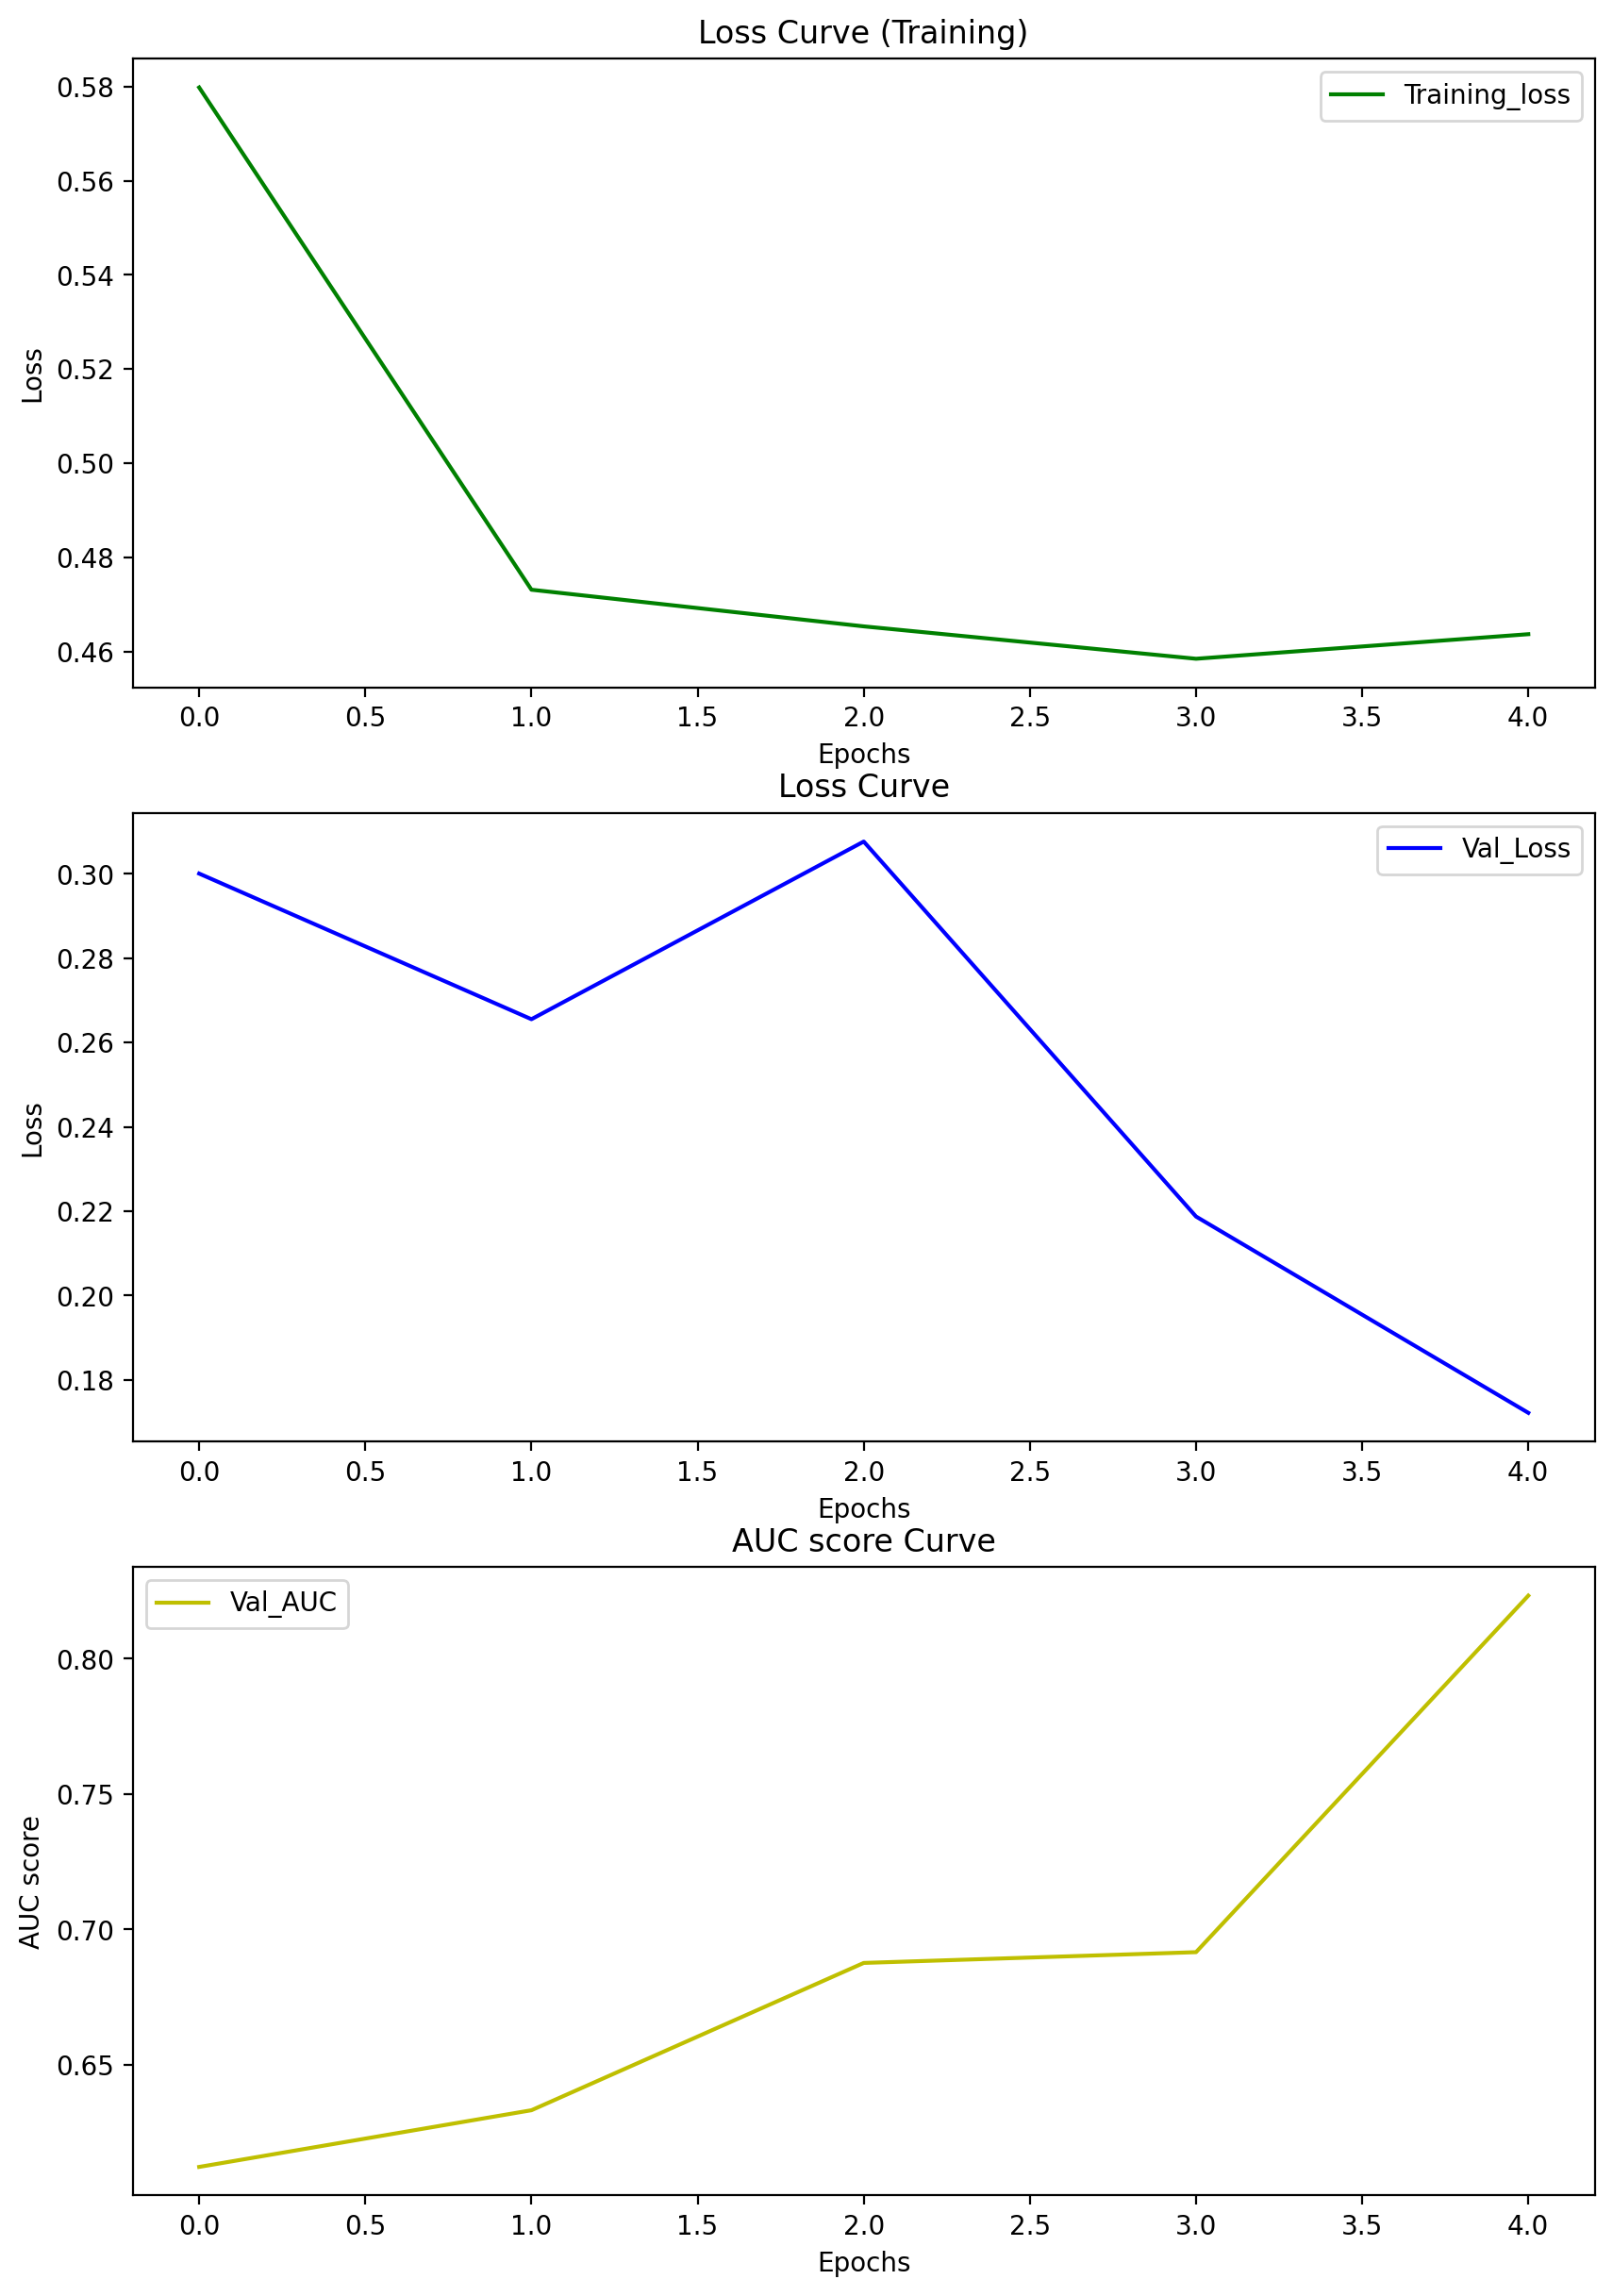

In [22]:
adamatch_train.train()

In [25]:
# change the paths accordingly where you store
e_path = './Encoder_val_auc 0.8232612589362185.pth'
c_path = './Classifier_val_auc 0.8232612589362185.pth'

# Testing

  0%|          | 0/81 [00:00<?, ?it/s]

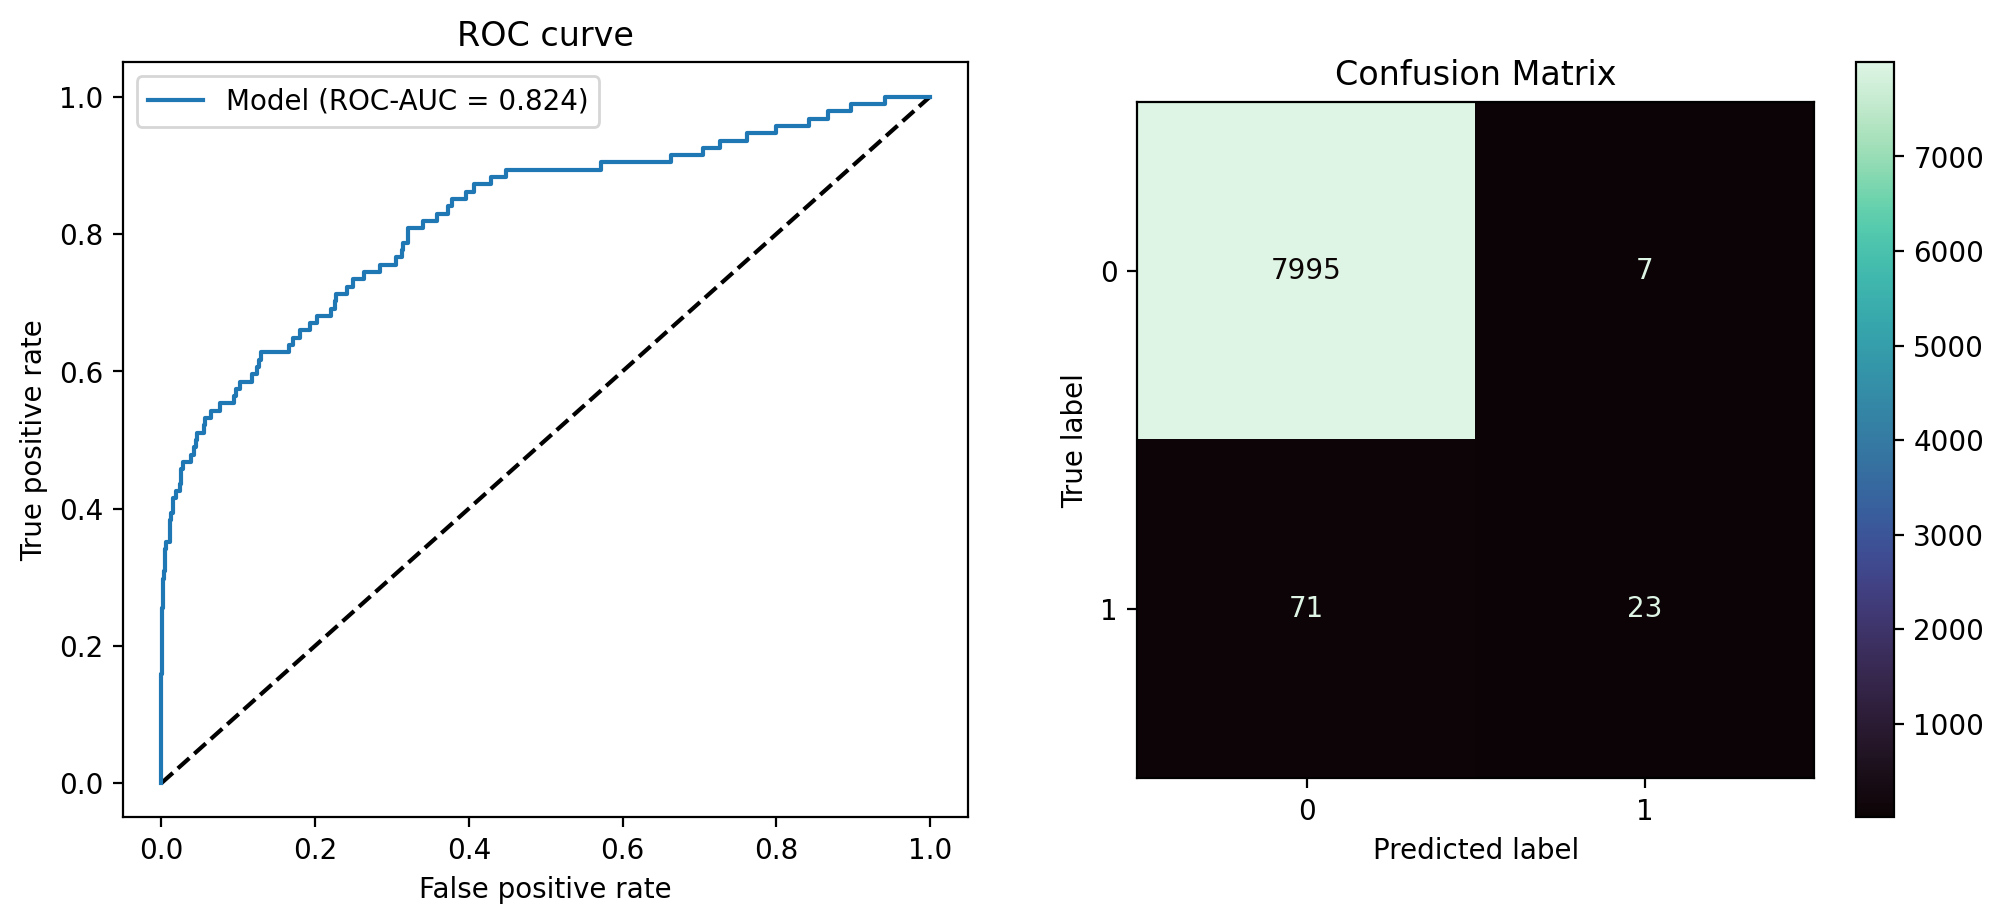

In [26]:
p,t = test_func(encoder ,  classifier,tv_loader , device, e_path, c_path )
plot_test_metrics(p,t)